In [2]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# Load Koch Meinhardt dataset


In [6]:
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*32,
                'pde_data_size': (T*N)//32,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': None,
                'signal_to_noise':0.0,
                'shuffle':False}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.concatenate([dataset['obs_input'], dataset['obs_output']], axis=1)
pde_X = dataset['pde']

pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

In [7]:
data.shape

(2, 32, 32, 512)

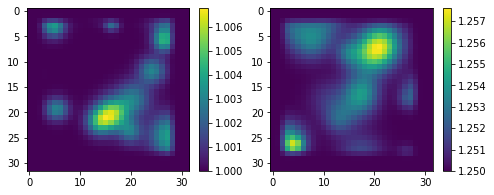

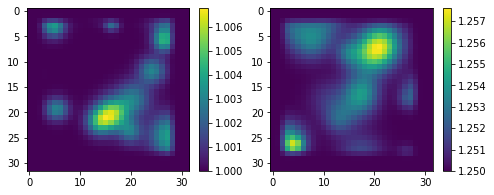

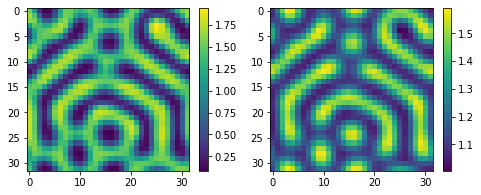

In [8]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(dataset['obs_output'][0:N, 0].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(dataset['obs_output'][0:N, 1].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

# _ = plt.figure(figsize=(8,4))
# plt.subplot(121)
# plt.imshow(dataset['obs_output'][(T-1)*N:, 0].reshape(x_size, y_size))
# plt.colorbar(shrink=.75)
# plt.subplot(122)
# plt.imshow(dataset['obs_output'][(T-1)*N:, 1].reshape(x_size, y_size))
# plt.colorbar(shrink=.75)
# plt.show()

In [9]:
model_params = {'training_data_size': T*32,
                'pde_data_size': (T*N)//32,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': None,
                'signal_to_noise':0.0,
                'shuffle':True}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.concatenate([dataset['obs_input'], dataset['obs_output']], axis=1)
pde_X = dataset['pde']

pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

In [10]:
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X, diffs)
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X)
ds = TINN_Dataset(tf.float32, obs_X, pde_X)#, pbc_X)

In [11]:
ds.sizes

array([16384, 16384])

In [12]:
#layers = [3, 1024, 1024, 1024, 1024, 2]
#layers = [3, 512, 512, 512, 512, 512, 2]
#layers = [3, 128, 128, 128, 128, 128, 2]
layers = [3, 64, 64, 64, 64, 2]
pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard(
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, .005, dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, 0.2, dtype=pinnKM.dtype),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),
                   # alpha_u = alpha_u,
                   # alpha_v = alpha_v,
                   regularise=True,
    )
# pde_resKM = Brusselator(
#                     D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
#                     D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, simulation.Ds[1], dtype=pinnKM.dtype),                    
#                     A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
#                     B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype), 
#                    regularise=True,
#     )
obs_loss = Observation_Loss(regularise=True)
pbc_loss = Periodic_Boundary_Condition(regularise=True)
# diff_loss_point = Diffusion_point_Loss(
#                            Ds = simulation.Ds,
#                            dtype = pinnKM.dtype)
# diff_loss = Diffusion_Loss(ns = simulation.n,
#                            Ls = simulation.L,
#                            Ds = simulation.Ds,
#                            dtype = pinnKM.dtype)

#nzp_loss = Non_zero_params("Koch_Meinhard", [pde_resKM.sigma_u.tf_var, pde_resKM.sigma_v.tf_var])

modelKM = tu.TINN(pinnKM, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  losses= [obs_loss, pde_resKM], 
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                  alpha = 0.5, 
                  print_precision=".8f")

In [13]:
16384/32

512.0

In [14]:
results_KM = modelKM.train(epochs = 1000+1,
                          batch_size = 512,
                          dataset = ds,
                          print_interval=100,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)




Start of epoch 0


2022-11-22 12:42:47.446404: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-11-22 12:42:53.569981: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 0.00000000
total loss: 110.17318320, total regularise loss: 110.17317200

Observation_Loss ->  (1): 0.80277185  (2): 1.15048422 
Loss_Koch_Meinhard ->  (1): 0.59852911  (2): 0.89112685 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

sigma_u: 0.98507 sigma_v: 0.98420 mu_u: 1.01636 rho_u: 0.98496 
rho_v: 1.01464 kappa_u: 0.98983 
Time taken: 17.32s

Start of epoch 100
Training observations acc over epoch: 0.00000000
total loss: 9.65453008, total regularise loss: 30.63836098

Observation_Loss ->  (1): 0.24245293  (2): 0.02317659 
Loss_Koch_Meinhard ->  (1): 0.01504255  (2): 0.02103199 


lambdas (1): 3.94420242 lambdas (2): 0.04542058 lambdas (3): 0.00547542 lambdas (4): 0.00490161 

sigma_u: 0.84378 sigma_v: 0.89839 mu_u: 1.21196 rho_u: 0.77996 
rho_v: 1.22059 kappa_u: 1.04349 
Time taken: 90.88s

Start of epoch 200
Training observations acc over epoch: 0.00000000
total loss: 8.93060967, total regu

In [ ]:
results_KM2 = modelKM.train(epochs = 4000+1,
                          batch_size = 512,
                          dataset = ds,
                          print_interval=100,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0
Training observations acc over epoch: 0.00000000
total loss: 0.39491961, total regularise loss: 1.23324120

Observation_Loss ->  (1): 0.01068343  (2): 0.00154475 
Loss_Koch_Meinhard ->  (1): 0.00000239  (2): 0.00011067 


lambdas (1): 3.55197811 lambdas (2): 0.37787807 lambdas (3): 0.00011895 lambdas (4): 0.07002513 

sigma_u: 0.00000 sigma_v: 0.02028 mu_u: 0.01354 rho_u: 0.01917 
rho_v: 0.02839 kappa_u: 0.60283 
Time taken: 1.97s

Start of epoch 100
Training observations acc over epoch: 0.00000000
total loss: 0.23358926, total regularise loss: 0.68784964

Observation_Loss ->  (1): 0.00617507  (2): 0.00102151 
Loss_Koch_Meinhard ->  (1): 0.00000096  (2): 0.00010213 


lambdas (1): 3.40032887 lambdas (2): 0.46313417 lambdas (3): 0.00008568 lambdas (4): 0.13645113 

sigma_u: 0.00000 sigma_v: 0.01866 mu_u: 0.00945 rho_u: 0.01084 
rho_v: 0.02141 kappa_u: 0.36861 
Time taken: 76.69s

Start of epoch 200
Training observations acc over epoch: 0.00000000
total loss: 0.16202626


Start of epoch 1800
Training observations acc over epoch: 0.00000000
total loss: 0.02814816, total regularise loss: 0.03951588

Observation_Loss ->  (1): 0.00059690  (2): 0.00019406 
Loss_Koch_Meinhard ->  (1): 0.00000076  (2): 0.00008791 


lambdas (1): 1.61962700 lambdas (2): 0.55220151 lambdas (3): 0.00074924 lambdas (4): 1.82742226 

sigma_u: 0.00000 sigma_v: 0.01817 mu_u: 0.00991 rho_u: 0.01098 
rho_v: 0.02014 kappa_u: 0.34177 
Time taken: 74.02s

Start of epoch 1900
Training observations acc over epoch: 0.00000000
total loss: 0.02628989, total regularise loss: 0.03615005

Observation_Loss ->  (1): 0.00054848  (2): 0.00018546 
Loss_Koch_Meinhard ->  (1): 0.00000075  (2): 0.00008686 


lambdas (1): 1.57852936 lambdas (2): 0.53883278 lambdas (3): 0.00074875 lambdas (4): 1.88188922 

sigma_u: 0.00000 sigma_v: 0.01812 mu_u: 0.00996 rho_u: 0.01103 
rho_v: 0.02013 kappa_u: 0.34280 
Time taken: 80.50s

Start of epoch 2000
Training observations acc over epoch: 0.00000000
total loss: 0.02

In [17]:
print(pde_resKM.trainables_str())

sigma_u: 0.00000 sigma_v: 0.01739 mu_u: 0.01008 rho_u: 0.01111 
rho_v: 0.01914 kappa_u: 0.33047 


- $D_u = 0.005, \quad D_v=0.2$.
- $\sigma_u = 0.0, \quad \sigma_v=0.02 \quad \mu_u = 0.01$.
- $\rho_u=0.01, \quad \rho_v = 0.02$.
- $\kappa_u=0.25$.

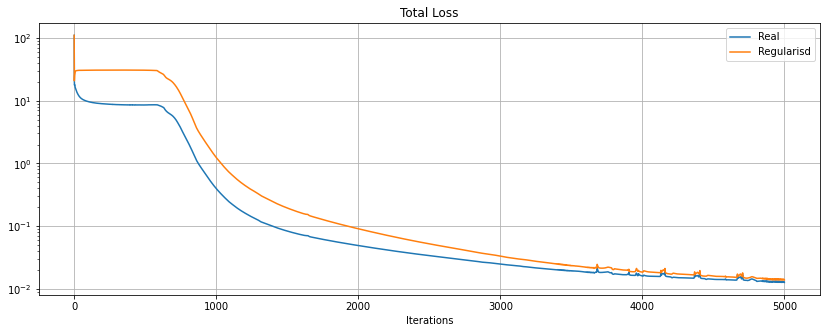

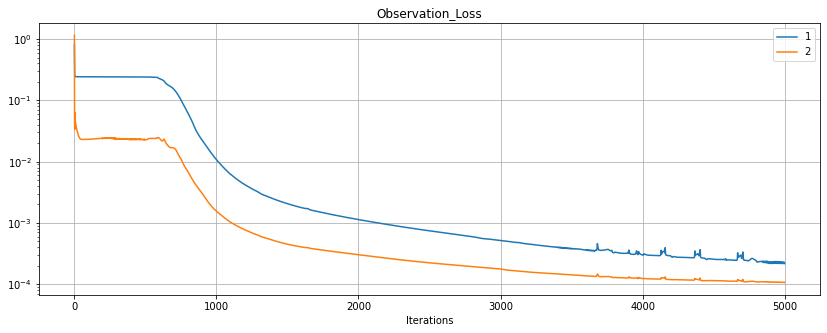

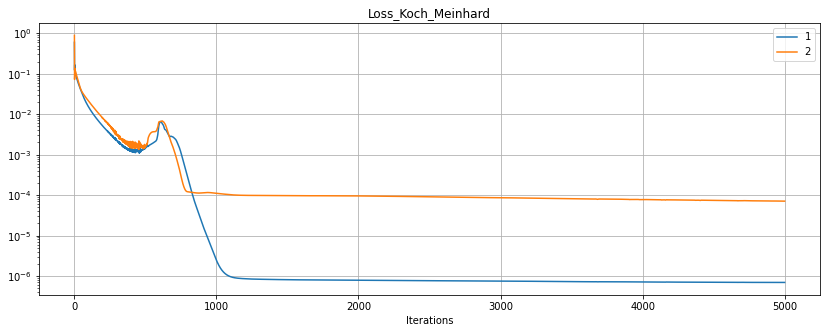

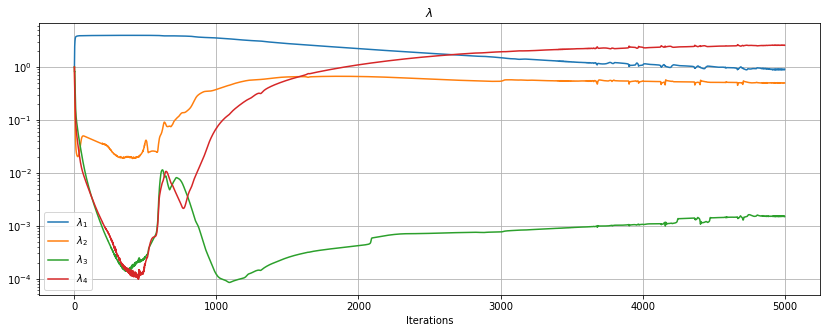

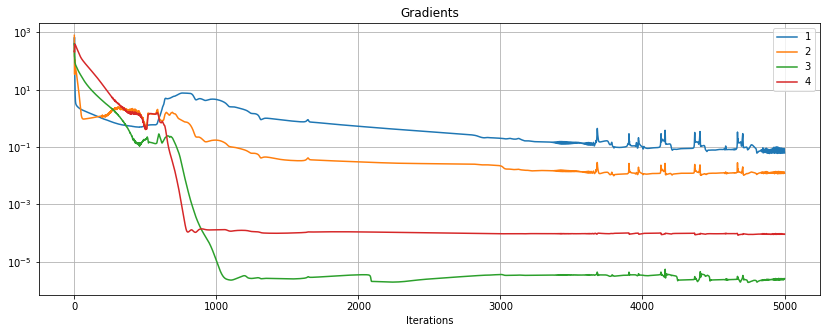

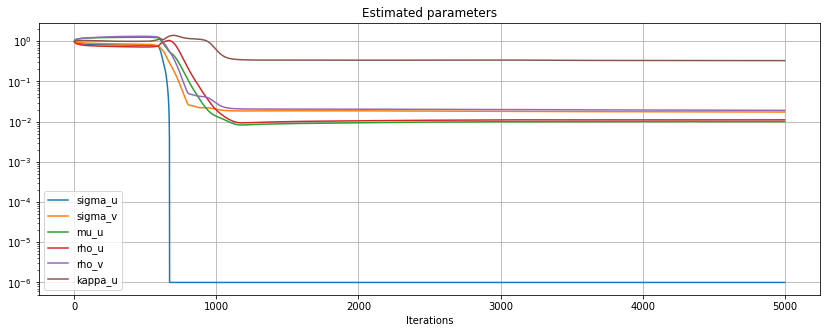

In [19]:
plot_result(merge_dict(results_KM, results_KM2), modelKM,
            param_names=pde_resKM.parameter_names(), yscale="log")

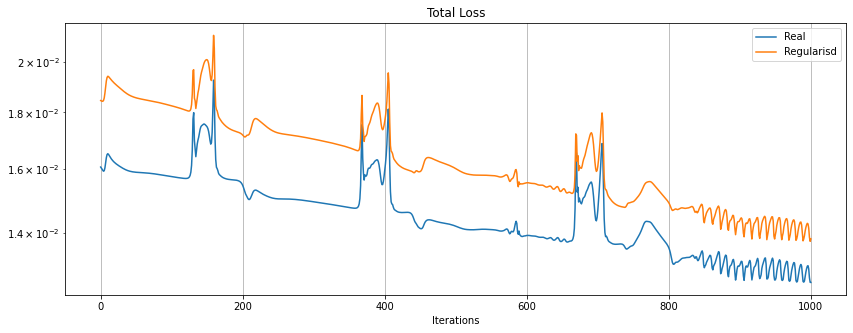

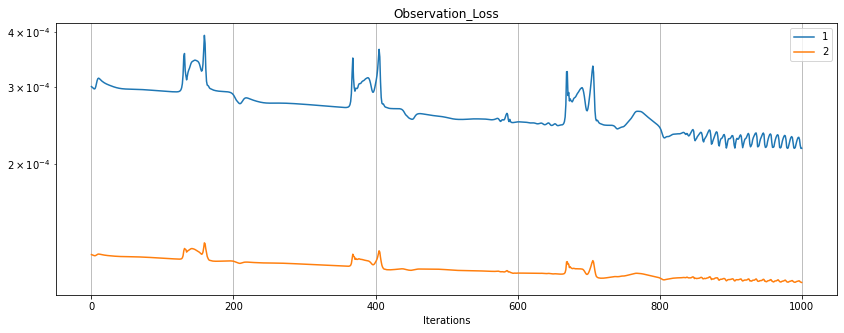

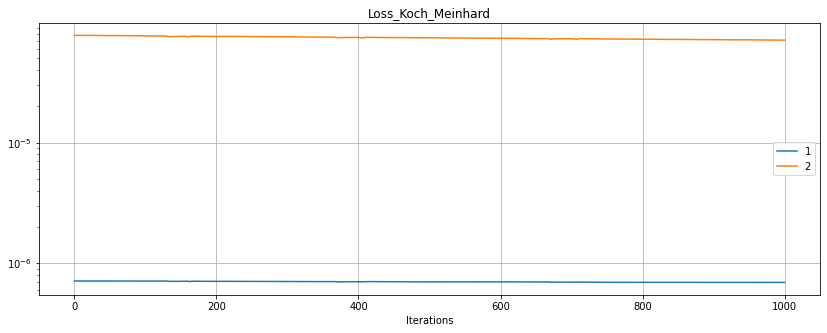

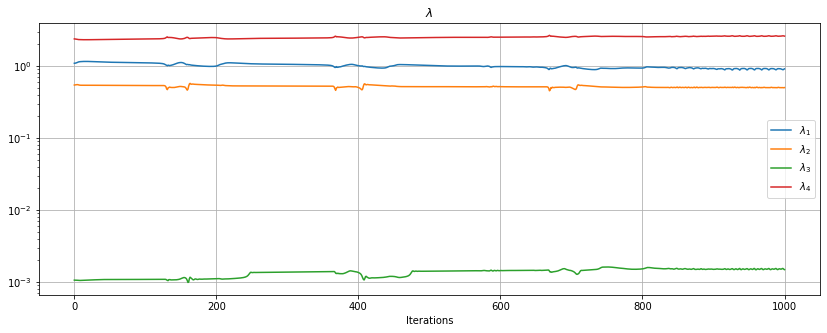

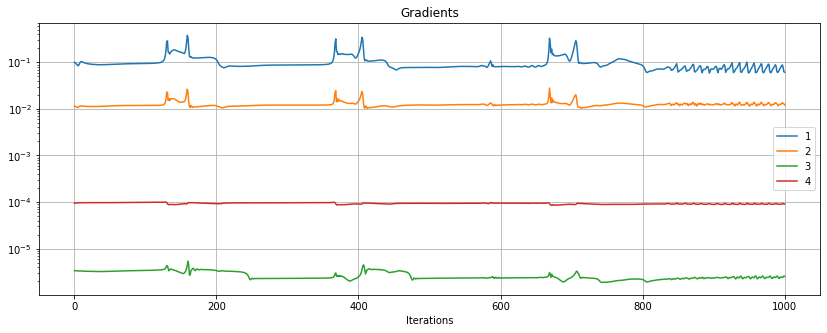

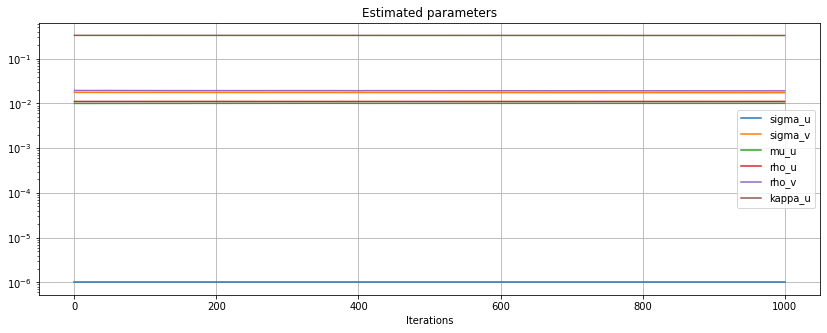

In [20]:
plot_result(merge_dict(results_KM, results_KM2), modelKM, start=4000,
            param_names=pde_resKM.parameter_names(), yscale="log")

# Second test: No fixed parameter but more data for training

In [72]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)
N2 = x_size * y_size


#T_test_index = -1#119
#T =224
index =-100
#T = 384.
T = t_star[index]
#T = 3000
#print(t_star[T_test_index])
print(T)
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(T, N2)  # 1 x N2
test_d = np.vstack([XX_test, YY_test, TT_test]).T.astype(np.float32)

40313.11154598826


In [60]:
from scipy.optimize import Bounds
bounds = Bounds([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])

In [61]:
minimize_parameters(pde_resKM, pinnKM, test_d,
                    [pde_resKM.rho_u, pde_resKM.rho_v, 
                     pde_resKM.sigma_u, pde_resKM.sigma_v,
                     pde_resKM.mu_u, pde_resKM.kappa_u], method='trust-constr',              
                     tol=1e-6, bounds=bounds)

 barrier_parameter: 1.2800000000000007e-06
 barrier_tolerance: 1.2800000000000007e-06
          cg_niter: 8
      cg_stop_cond: 0
            constr: [array([0.37988652, 0.28788493, 0.3029607 , 0.09896046, 0.41425218,
       3.08298378])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.2839992046356201
               fun: 36.72535
              grad: array([0., 0., 0., 0., 0., 0.])
               jac: [<6x6 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([-4.24931310e-07, -3.40290232e-07, -3.55188637e-07, -1.25440922e-07,
       -4.52578176e-07, -3.75659068e-07])
           message: '`gtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 42
              nhev: 0
               nit: 13
             niter: 13
              njev: 0
        optimality: 4.525781759605

In [73]:
output_test = pinnKM(test_d)
output_test = np.array([output_test[:, i].numpy().reshape((x_size, y_size)) 
                        for i in range(output_test.shape[1])]) 

In [76]:
#test_d = np.vstack([XX_test, YY_test, TT_test]).T.astype(np.float32)
test_outputs = np.zeros((test_d.shape[0], 2))
#test_pde_u = np.zeros(test_d.shape[0])
#test_pde_v = np.zeros(test_d.shape[0])
pde_u, pde_v = pde_resKM.residual(pinnKM, test_d)
test_outputs = np.array([test_outputs[..., i].reshape(x_size, y_size) for i in range(2)])
#test_outputs[i] = outs.numpy()
test_pde_u = pde_u.numpy().reshape(x_size, y_size)
test_pde_v = pde_v.numpy().reshape(x_size, y_size)

In [77]:
print(np.mean((output_test[0, ...]-data[0,:,:, index])**2))
print(np.mean((output_test[1, ...]-data[1,:,:, index])**2))
print(np.sqrt(np.mean((output_test[0, ...]-data[0,:,:, index])**2)))
print(np.sqrt(np.mean((output_test[1, ...]-data[1,:,:, index])**2)))
print(np.max(test_pde_u))
print(np.max(test_pde_v))
print(np.sqrt(np.mean(test_pde_u**2)))
print(np.sqrt(np.mean(test_pde_v**2)))

0.00015971019114722625
9.689695724339462e-05
0.012637649747766641
0.00984362520839729
0.3640927
0.0073800087
0.18716477
0.03396933


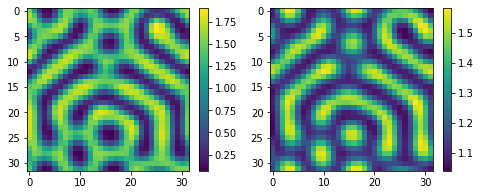

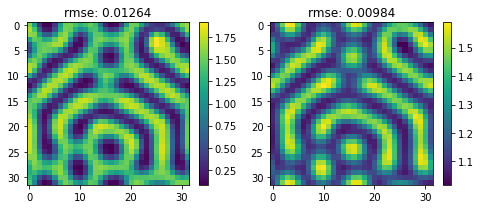

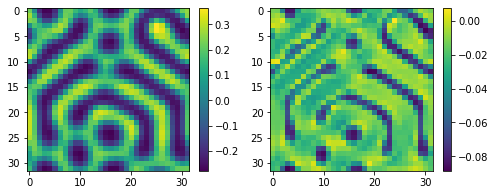

In [78]:

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(output_test[0, ...])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(output_test[1, ...])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
rmse = np.sqrt(np.mean( (output_test[0, ...]-data[0,:,:, index])**2 ))#/np.max(data[0,:,:, index])
plt.title(f"rmse: {rmse:.5f}")
plt.imshow(data[0,:,:, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
rmse = np.sqrt(np.mean( (output_test[1, ...]-data[1,:,:, index])**2 ))#/np.max(data[1,:,:, index])
plt.title(f"rmse: {rmse:.5f}")
plt.imshow(data[1,:,:, index])
plt.colorbar(shrink=.75)
plt.show()

#index = 0
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)
plt.show()

In [79]:
@tf.function
def derivatives(pinn, x):
    return pde_resKM.derivatives(pinn, x)

In [80]:
y, u, u_t, u_xx, u_yy, v, v_t, v_xx, v_yy = derivatives(pinnKM, test_d)
D_u = pde_resKM.D_u.get_value(test_d)
D_v = pde_resKM.D_v.get_value(test_d)
sigma_u = pde_resKM.sigma_u.get_value(test_d) / pde_resKM.alpha_u
sigma_v = pde_resKM.sigma_v.get_value(test_d) / pde_resKM.alpha_v
mu_u = pde_resKM.mu_u.get_value(test_d)
rho_u = pde_resKM.rho_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_v
rho_v = pde_resKM.rho_v.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u
kappa_u = pde_resKM.kappa_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u
#A = kappa_u = pde_resKM.A.get_value(test_d) 
#B = kappa_u = pde_resKM.B.get_value(test_d) 

In [85]:
diffusion_u = D_u * (u_xx + u_yy)
diffusion_v = D_v * (v_xx + v_yy)

dxdy = x_size * y_size/ L**2
diffusion_u_space = D_u * dxdy * diffusion([x_size, y_size], u.numpy().reshape(x_size, y_size))
diffusion_v_space = D_v * dxdy * diffusion([x_size, y_size], v.numpy().reshape(x_size, y_size))


f = u * u * v / (1.0 + kappa_u * u * u)
non_lin_u = -rho_u * f
non_lin_v = rho_v * f
f_u = - rho_u * f + mu_u * u - sigma_u
f_v = rho_v * f - sigma_v
d_t_u = - D_u * (u_xx + u_yy) - rho_u * f + mu_u * u - sigma_u
d_t_v = -D_v * (v_xx + v_yy) + rho_v * f - sigma_v


diff_Y = np.array([[dxdy * [0.005, 0.2][c] *diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)
#u2v = u * u * v

#non_lin_u = -u2v
#non_lin_v = u2v
#f_u = - A + (B + 1) * u - u2v
#f_v = - B * u + u2v
#d_t_u = - D_u * (u_xx + u_yy) + f_u
#d_t_v = - D_v * (v_xx + v_yy) + f_v

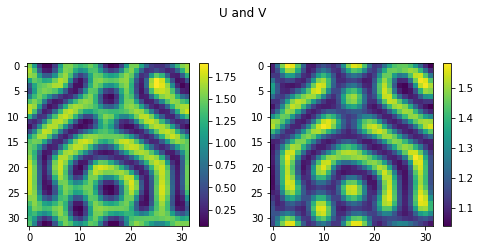

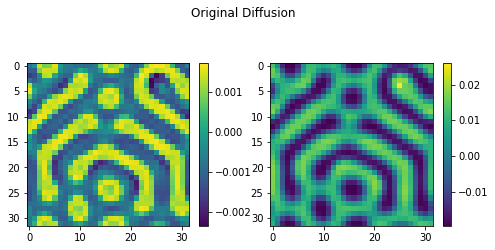

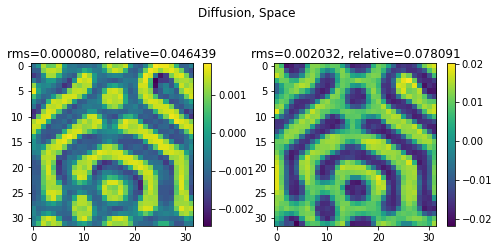

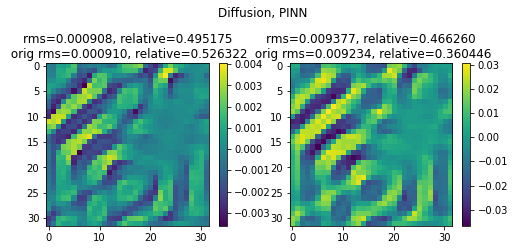

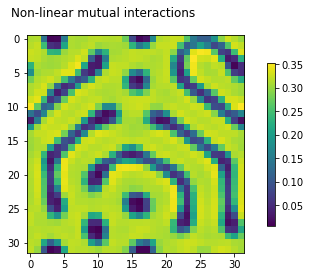

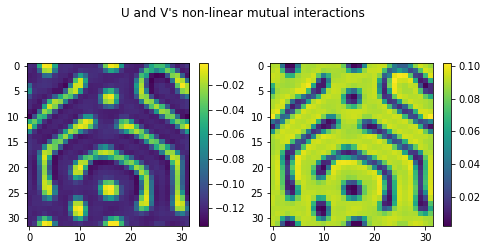

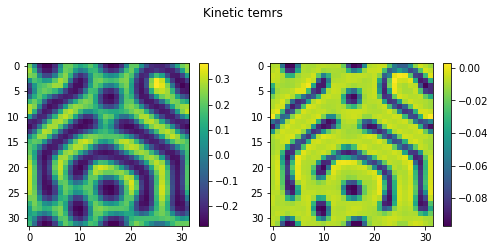

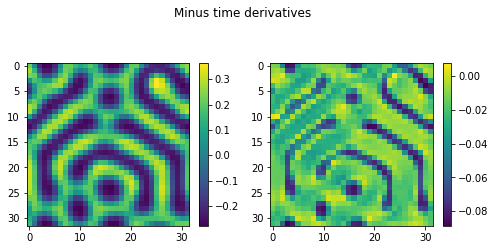

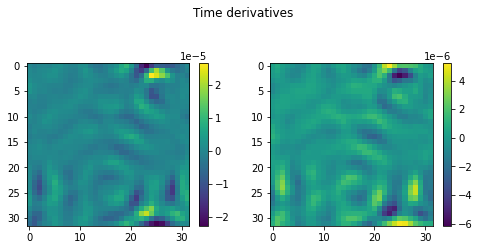

In [86]:
#index = 0
_ = plt.figure(figsize=(8,4))
plt.suptitle("U and V")
plt.subplot(121)
plt.imshow(u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Original Diffusion")
plt.subplot(121)
plt.imshow(diff_Y[0, :, :, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(diff_Y[1, :, :, index])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Diffusion, Space")
plt.subplot(121)
rms = np.sqrt(np.mean((diff_Y[0, :, :, index]-diffusion_u_space)**2))
relative_rms = rms/np.max(diff_Y[0, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}")
plt.imshow(diffusion_u_space)
plt.colorbar(shrink=.75)
plt.subplot(122)
rms = np.sqrt(np.mean((diff_Y[1, :, :, index]-diffusion_v_space)**2))
relative_rms = rms/np.max(diff_Y[1, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}")
plt.imshow(diffusion_v_space)
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Diffusion, PINN")
plt.subplot(121)
rms = np.sqrt(np.mean((diffusion_u.numpy().reshape(x_size, y_size)-diffusion_u_space)**2))
relative_rms = rms/np.max(diffusion_u_space)
rms2 = np.sqrt(np.mean((diff_Y[0, :, :, index]-diffusion_u.numpy().reshape(x_size, y_size))**2))
relative_rms2 = rms/np.max(diff_Y[0, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}\n orig rms={rms2:.6f}, relative={relative_rms2:.6f}")
plt.imshow(diffusion_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
rms = np.sqrt(np.mean((diffusion_v.numpy().reshape(x_size, y_size)-diffusion_v_space)**2))
relative_rms = rms/np.max(diffusion_v_space)
rms2 = np.sqrt(np.mean((diff_Y[1, :, :, index]-diffusion_v.numpy().reshape(x_size, y_size))**2))
relative_rms2 = rms/np.max(diff_Y[1, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}\n orig rms={rms2:.6f}, relative={relative_rms2:.6f}")
plt.imshow(diffusion_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()



_ = plt.figure(figsize=(8,4))
plt.suptitle("Non-linear mutual interactions")
plt.imshow(f.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("U and V's non-linear mutual interactions")
plt.subplot(121)
plt.imshow(non_lin_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(non_lin_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Kinetic temrs")
plt.subplot(121)
plt.imshow(f_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(f_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Minus time derivatives")
plt.subplot(121)
plt.imshow(d_t_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(d_t_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Time derivatives")
plt.subplot(121)
plt.imshow(u_t.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(v_t.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()